Finished creating the dataset, time to load it in

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import random


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Setting Up Transforms
temp_tf = transforms.ToTensor()

temp_ds = ImageFolder("Training_mon/final/train", transform=temp_tf)
stats_loader = DataLoader(temp_ds, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
n_samples = 0

for data, _ in stats_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # flatten H*W
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

print(mean)
print(std)

#Loading Dataset
train_ds = ImageFolder("Training_mon/final/train", transform=train_tf)
val_ds = ImageFolder("Training_mon/final/val", transform=val_tf)
test_ds = ImageFolder("Training_mon/final/test", transform=test_tf)

#Creating Dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=True)




tensor([0.8286, 0.8175, 0.7979])
tensor([0.2652, 0.2749, 0.2993])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1239831..0.67522836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.

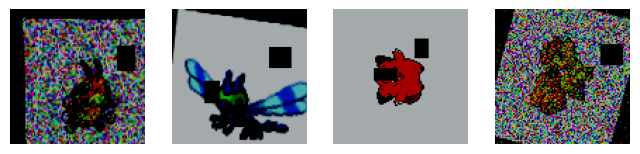

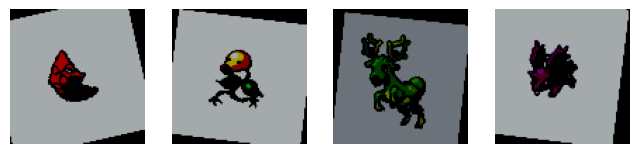

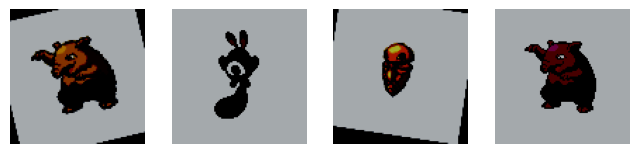

In [20]:
x_next_train, y_next_train = next(iter(train_loader))
x_next_val, y_next_val = next(iter(val_loader))
x_next_test, y_next_test = next(iter(test_loader))

#Training
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_train[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

#Validation
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_val[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

#Testing
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_test[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

In [21]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_class = 30):
        super().__init__()
        #Main part of CNN Layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
        )
        #Classifier section of CNN
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            #From Task 5
            nn.Dropout(0.5),
            nn.Linear(512, num_class)
            #Don't need softmax here, because crossEntropy() function already includes it
        )

    #Forward pass function
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
#Transfer Learning - MobileNetV2
import torchvision.models as models
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

#Hyperparameters

#Transfer Learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Net = CNN().to(device)

#Assign Device
model_Net = model_Net.to(device)

#creating Loss Function
entropy = nn.CrossEntropyLoss()

#Creating Optimizer
optimizer = torch.optim.AdamW(model_Net.parameters(),
                            lr=1e-3,
                            weight_decay=1e-4)

#LR_Scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max = 25, eta_min=1e-5)

In [23]:
def train_loop(dataloader, model, loss_fn, opt, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0,0

    #Setting Model to Training Mode
    model.train()

    #Looping through dataloader
    for batch, (X,y) in enumerate(dataloader):
        #Computing Prediction and Loss
        X,y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        #Backdrop Section
        opt.zero_grad()
        loss.backward()
        opt.step()

        #Metric Calculations
        train_loss += loss.item() * X.size(0)
        train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    #Averaging Loss and Accuracy
    train_loss /= size
    train_acc /= size

    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn, device):
    #Setting model to eval mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0,0

    #Looping through dataloader
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            y_pred = model(X)

            #Calculating Metric
            test_loss += loss_fn(y_pred,y).item() * X.size(0)
            test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    #Averaging Metrics
    test_loss /= size
    test_acc /= size

    return test_loss, test_acc

In [24]:
#Training
#Lists for training and validation
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epochs = 25 #Running for 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    train_loss, train_acc = train_loop(train_loader, model_Net, entropy, optimizer, device)
    val_loss, val_acc = test_loop(val_loader, model_Net, entropy, device)

    #Appending lists with loss and accuracy calculated per epoch
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    #Incrementing LR Scheduler
    before_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    after_lr = optimizer.param_groups[0]['lr']
    #Displaying Learning Rate per epoch
    print("Epoch %d: SGD lr %.4f -> %.4f" % (t, before_lr, after_lr))


    #Displaying losses and accuracies
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Validation  Loss: {val_loss:.4f}, Test  Acc: {val_acc*100:.2f}%\n")

print("Done!")

Epoch 1
-----------------------
Epoch 0: SGD lr 0.0010 -> 0.0010
Train Loss: 3.3874, Train Acc: 3.98%
Validation  Loss: 3.2428, Test  Acc: 7.00%

Epoch 2
-----------------------
Epoch 1: SGD lr 0.0010 -> 0.0010
Train Loss: 2.9568, Train Acc: 9.69%
Validation  Loss: 2.7236, Test  Acc: 7.83%

Epoch 3
-----------------------
Epoch 2: SGD lr 0.0010 -> 0.0010
Train Loss: 2.7129, Train Acc: 11.36%
Validation  Loss: 2.6071, Test  Acc: 13.33%

Epoch 4
-----------------------
Epoch 3: SGD lr 0.0010 -> 0.0009
Train Loss: 2.5992, Train Acc: 13.69%
Validation  Loss: 2.5033, Test  Acc: 14.67%

Epoch 5
-----------------------
Epoch 4: SGD lr 0.0009 -> 0.0009
Train Loss: 2.5131, Train Acc: 15.05%
Validation  Loss: 2.3935, Test  Acc: 15.83%

Epoch 6
-----------------------
Epoch 5: SGD lr 0.0009 -> 0.0009
Train Loss: 2.2967, Train Acc: 22.02%
Validation  Loss: 2.1557, Test  Acc: 22.33%

Epoch 7
-----------------------
Epoch 6: SGD lr 0.0009 -> 0.0008
Train Loss: 1.9471, Train Acc: 31.83%
Validation  L

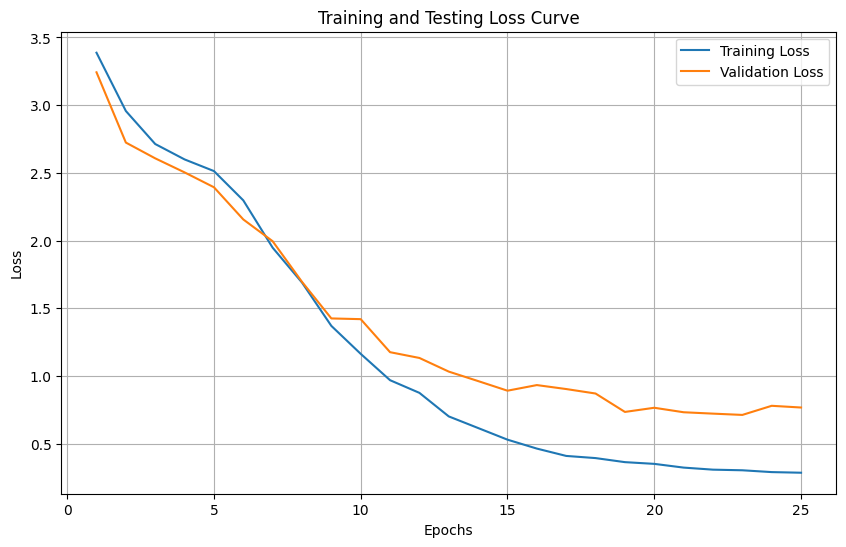

In [25]:
#Training and Validation Loss Curves

epoch_plot = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_plot, train_losses, label='Training Loss')
plt.plot(epoch_plot, val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

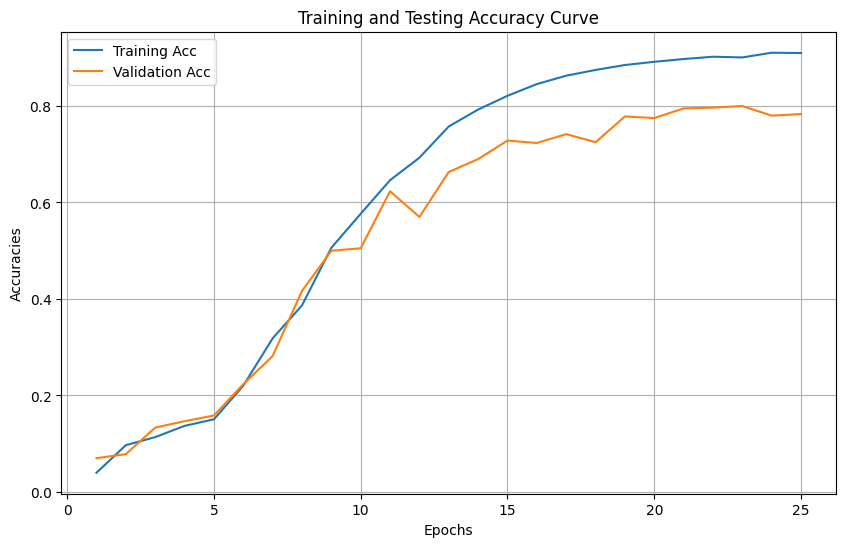

In [26]:
#Training and Validation Accuracy Curves

plt.figure(figsize=(10, 6))
plt.plot(epoch_plot, train_accs, label='Training Acc')
plt.plot(epoch_plot, val_accs, label='Validation Acc')
plt.title('Training and Testing Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.grid(True)
plt.show()

Evaluation Metrics Section

In [27]:
#Evaluating Model: accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

#Method to calculate Performance Metrics
def eval_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labs = []

    #Collecting Predictions and Labels
    with torch.no_grad(): #Turns off Gradient Tracking
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            #Calculating Predictions
            y_pred = model(X)
            y_preds = y_pred.argmax(1)

            all_preds.extend(y_preds.cpu().tolist())
            all_labs.extend(y.cpu().tolist())
    
    #Creating Confusion Matrix
    
    cm = confusion_matrix(all_labs, all_preds)
    np.set_printoptions(linewidth=200)
    print(cm)


    #Calculating Performance Metrics
    acc = accuracy_score(all_labs, all_preds)
    precision = precision_score(all_labs, all_preds, average='macro')
    recall = recall_score(all_labs, all_preds, average = 'macro')
    f1 = f1_score(all_labs, all_preds, average='macro')

    return acc, precision, recall, f1, np.array(all_preds), np.array(all_labs), cm

In [28]:
test_acc, test_prec, test_recall, test_f1, y_pred, y_true, cm = eval_model(model_Net, test_loader, device)

print("Accuracy :", test_acc)
print("Precision:", test_prec)
print("Recall   :", test_recall)
print("F1 Score :", test_f1)
cm_norm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm_norm)

[[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 23 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  4  0 20  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0 37  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0

Saving the Model

In [29]:
#This saves the model to the Model folder
path = "Model/mon_classifier.pt"
torch.save(model_Net, path)
